In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import warnings 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import geopy
from geopy.geocoders import Nominatim
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
scaler = StandardScaler()
%matplotlib inline

In [55]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
train['Travel Date'] = pd.to_datetime(train['Travel Date'])
test['Travel Date'] = pd.to_datetime(test['Travel Date'])

In [56]:
# get column  names by datatype
month = ['nan','January','February','March','April','May','June','July','August','September','October','November','December']
def get_col_names_by_dtype(df, type_ = 'object'):
  dtypes = df.dtypes
  col_names = dtypes[dtypes == type_].index
  count = len(col_names)
  print("{} columns found for given datatype {}".format(count, type_))
  return  col_names

def get_unique_elements(col):
  return col.unique()

def ordinal_encoder(col_name, df):
  categories = ['Budget','Standard','Premium', 'Deluxe','Luxury']
  col = df[col_name]
  for i in categories:
    col[col == i] = categories.index(i)
  col.astype('int')
  df[col_name] = col
  df[col_name] = df[col_name].astype('int')

def get_places(col):
  temp_list = []
  for i in col:
    for k in i.split('.'):
      temp_list.append(re.split('[0-9]+N' ,k )[1].strip())
  temp_list = set(temp_list)
  return list(temp_list)

def convert_to_cols(train):
  A = np.zeros((train.shape[0], len(get_places(test['Itinerary']))))
  A = pd.DataFrame(A)
  temp_list = get_places(test['Itinerary'])
  check_list = temp_list.copy()
  for i in range(len(temp_list)):
    temp_list[i] = 'Nights in ' + temp_list[i]
  A.columns = temp_list
  for i in train['Itinerary']:
    for k in i.split('.'):
      temp_list.append(re.split('[0-9]+N' ,k )[1].strip())
  return check_list, A

def set_mean(x):
  nums = ['zero','one','two','three','four','five']
  l = x.split('|')
  m = []
  try:
    for i in l:
      m.append(float(i))
  except ValueError:
    m.append(nums.index(i.lower()))
  m = np.array(m)
  return m.mean()



def sort_hotels(x):
  a = x.split('|')
  a.sort()
  a = '|'.join(a)
  return a


def update_cols( col, check_list, A):
  for i in range(len(col)):
   for k in col[i].split('.'):
     places = re.split('[0-9]+N' ,k )[1].strip() 
     x=re.search('[0-9]+N' ,k )
     duration = x.group().strip()
     duration = int(duration.split('N')[0])
     column_ = 'Nights in ' + places
     A.iloc[i][column_] = duration
  return A
  
def  datetime_to_month(df):
  df['Travel Date']=df['Travel Date'].apply(lambda x : x.month)

def get_categorical_cols(train):
  categorical_ = []
  for i in train.columns:
    if train[i].dtype == 'object':
      categorical_.append(i)
  return categorical_


def filter_ratings(x):
  ab =[]
  c = ''
  for i in x.split('|'):
    if i == 'Not Available':
      c = '3'
      return c
    else:
      if i.split(':')[1] == '':
        ab.append('3')
      else:
        ab.append(i.split(':')[1])
    c= '|'.join(ab)
  return c



def convert_to_month_name(x):
  m = month[x]
  return m

def process_test_data(df):
  df['Hotel Details'] = df['Hotel Details'].apply(lambda x : sort_hotels(x))
  df.drop(['Uniq Id','Package Name','Destination','Places Covered','Sightseeing Places Covered','Airline','Cancellation Rules','Start City'], axis=1, inplace= True)
  ordinal_encoder('Package Type',df)
  check_list , A = convert_to_cols(df)
  A= update_cols( df['Itinerary'], check_list, A)
  df.drop('Itinerary',axis=1,inplace=True)
  df = pd.concat([df,A],axis = 1)
  df['Travel Date']=df['Travel Date'].apply(lambda x : x.month)
  df['Travel Date'] = df['Travel Date'].astype('int')
  df['Hotel Details'] = df['Hotel Details'].apply(lambda x : filter_ratings(x))
  df['Hotel Details'] = df['Hotel Details'].apply(lambda x: set_mean(x))
  c = [i for i in range(13)]
  c.remove(0)
  colname = ['Month #' + str(i) for i in c]
  print(colname)
  A = pd.DataFrame(np.zeros((df.shape[0],len(colname))))
  A.columns = colname
  for i in range(df.shape[0]):
   d = df.iloc[i]['Travel Date']-1
   g = colname[int(d)]
   A.iloc[i][g] = 1
  print(A)
  df = pd.concat([df,A],axis=1)
  df.drop(['Travel Date'], axis = 1, inplace = True)
  A = create_nation_column(df)
  df = pd.concat([A,df],axis=1)
  df.rename(columns = {0: 'National Trip'}, inplace = True) 
  return df

#------------------utils-------------------------------

import os
def create_submission(test, p, s):
  Y_unseen = p.predict(test.values)
  Y_un = scaler.inverse_transform(np.asarray(Y_unseen).reshape(-1,1))
  Y_un = pd.DataFrame(Y_un)
  Y_un.columns =['Per Person Price']
  n = './submission' + s +'.csv'
  Y_un.to_csv(n)
  print("--Ready--")

def get_log_error(Y_CV, Y_P):
  s = np.sqrt(mean_squared_log_error(Y_CV, Y_p))
  return s


def nation(x):
  geolocator = Nominatim(user_agent = "geoapiExercises")
  location = geolocator.geocode(x)
  if location == None:
    return 'nan'
  a = list(location)
  a= a[-2]
  a = a.split(',')
  return a[-1]

def create_nation_column(df): # df.iloc[0]
  indian_locs =[]
  A = pd.DataFrame(np.zeros(df.shape[0]).reshape(df.shape[0],1))
  places =[i for i in df.columns if 'Nights in' in i]
  for i in places:
    if nation(i.split('Nights in ')[1] ).strip() == None:
      continue
    if nation(i.split('Nights in ')[1] ).strip() == 'India':
      print(i.split('Nights in ')[1])
      indian_locs.append(i)

  for i in range(df.shape[0]):
    test_col = df.iloc[i][places] == 1
    for j in test_col[test_col == True].index:
      if j in places:
        A.iloc[i] = 1
  return A

In [57]:
train['Hotel Details'] = train['Hotel Details'].apply(lambda x : sort_hotels(x))
test['Hotel Details'] = test['Hotel Details'].apply(lambda x : sort_hotels(x))

In [58]:
print(len(set(train['Hotel Details']) - set(test['Hotel Details']) ))
print(len(set(train['Hotel Details'])))
print(len(set(test['Hotel Details'])))

3166
5526
3420


**EDA**

In [59]:
train.describe()
train.iloc[20999]['Hotel Details']

'Hotel Royale Park:|Iceberg Hill Hotel-MMT Holidays Special:3.8|Sagara Beach Resort - MMT Holidays Special:'

In [60]:
print(test.describe())
print('Train data shape: ',train.shape)

       Flight Stops        Meals
count   9000.000000  9000.000000
mean       0.881000     3.661333
std        0.841973     0.894834
min        0.000000     2.000000
25%        0.000000     3.000000
50%        1.000000     3.000000
75%        2.000000     5.000000
max        2.000000     5.000000
Train data shape:  (21000, 15)


In [61]:
train.head(20)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,2021-07-30,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,2021-08-12,The Orchard Retreat & Spa:4.6|The Orchard Retr...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,2021-04-26,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2021-08-27,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,2021-12-12,Amari Watergate Hotel Bangkok - MMT Special:4....,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0
5,3bb074528941b3a6823371f77b07fb0f,Cochin Trip with Visit to Guruvayoor Temple,Deluxe,Cochin,2N Cochin,Cochin,2021-09-30,Not Available,Mumbai,IndiGo,1,3,Dutch Palace | Jewish Synagogue | St. Francis...,Not Available,8512.0
6,644c71b1a9ccfe6eacc6303be12c1352,Jaipur Holiday,Standard,Jaipur,3N Jaipur,Jaipur,2021-01-24,Ratnawali A Vegetarian Heritage Hotel:4.1,New Delhi,IndiGo,2,3,Hawa Mahal | City Palace | Jantar Mantar | Am...,Cancellation any time after making the 1st pay...,6848.0
7,07943295cfdce5cb20861e8369948b1d,Kasol & Manali holiday from Delhi,Deluxe,Kasol|Manali,2N Kasol . 3N Manali,Kasol|Manali,2021-10-12,The Himalayan Village:Four|The Holiday Resorts...,Mumbai,Not Available,1,3,Pandoh Dam | Hadimba Temple | Tibetan Monaste...,Cancellation any time after making the 1st pay...,14454.5
8,126e12c63233bf11ef2e001a062f2a53,Charismatic Kashmir with Gulmarg,Deluxe,Srinagar|Gulmarg|Pahalgam|Srinagar,1N Srinagar . 1N Gulmarg . 2N Pahalgam . 2N Sr...,Srinagar|Gulmarg|Pahalgam|Srinagar,2021-03-10,California Group of Houseboats:3.6|California ...,New Delhi,IndiGo,1,3,Dal Lake | Gondola Point | Avantipura Ruins |...,Cancellation any time after making the 1st pay...,21556.5
9,72aeb7bac6d5600fe443fca06e3db631,Luxury Getaway to Udaipur - Stay at the Chunda...,Premium,Udaipur,2N Udaipur,Udaipur,2021-08-15,Chunda Palace:4.6,Mumbai,IndiGo,0,5,Lake Pichola | Jag Mandir Palace | Sajjangarh...,This cancellation policy is applicable for boo...,13042.0


In [62]:
train.nunique()

Uniq Id                       21000
Package Name                   2204
Package Type                      5
Destination                     565
Itinerary                       966
Places Covered                  565
Travel Date                     495
Hotel Details                  5526
Start City                        2
Airline                         314
Flight Stops                      3
Meals                             4
Sightseeing Places Covered     1714
Cancellation Rules               10
Per Person Price              17138
dtype: int64

In [63]:
print("NA's in dataset\n\n")
print(train.isna().sum())

NA's in dataset


Uniq Id                       0
Package Name                  0
Package Type                  0
Destination                   0
Itinerary                     0
Places Covered                0
Travel Date                   0
Hotel Details                 0
Start City                    0
Airline                       0
Flight Stops                  0
Meals                         0
Sightseeing Places Covered    0
Cancellation Rules            0
Per Person Price              0
dtype: int64


In [64]:
#1 drop some cols
train.drop(['Uniq Id','Package Name','Destination','Places Covered','Sightseeing Places Covered','Cancellation Rules', 'Airline'], axis=1, inplace= True)

In [65]:
col_names = get_col_names_by_dtype(train)


4 columns found for given datatype object


In [66]:
col_names

Index(['Package Type', 'Itinerary', 'Hotel Details', 'Start City'], dtype='object')

In [67]:
# pre processing ordinal encoder  Budget < Standard < Premium < Deluxe < Luxury
elements = get_unique_elements(train['Package Type'])
elements
ordinal_encoder('Package Type',train)
#Pipeline element #1  Ordinal Data encoder

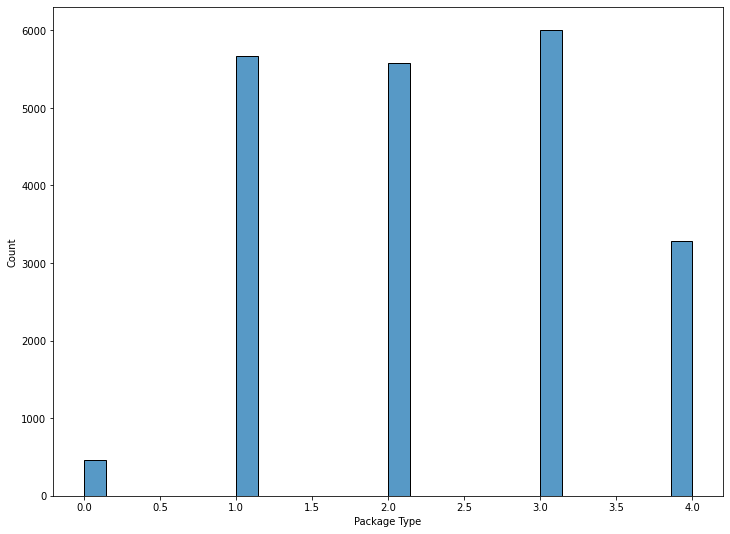

In [68]:
plt.figure(figsize=(12,9))
sns.histplot(data = train['Package Type'], kde = False)
plt.show()

In [69]:
#plot package type vs cost / date vs cost 
mean =[]
for i in np.sort(train['Package Type'].unique()):
  mean.append(train['Per Person Price'][train['Package Type']==i].mean())
p_type =[i for i in range(len(mean))]


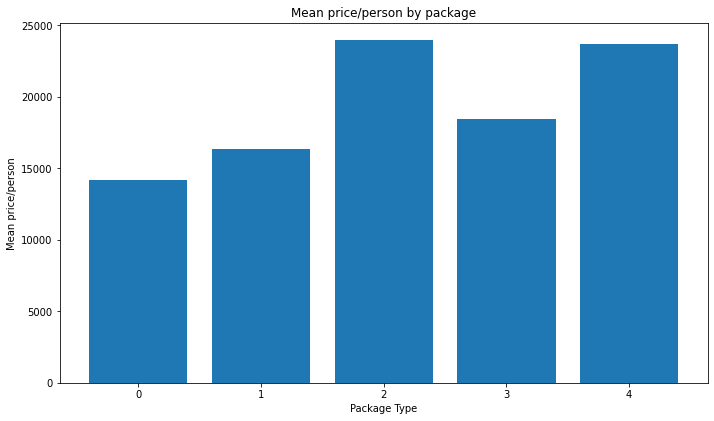

In [70]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(p_type,mean)
plt.title("Mean price/person by package")
plt.xlabel("Package Type")
plt.ylabel("Mean price/person")
plt.show()

Discrepancies in prices are due to the fact that international and national trips are included thus the mean price seems to be the same. Dummy variables for destinations may help capture this information.

In [71]:
print(len(get_places(train['Itinerary'])))
print(get_places(train['Itinerary']))
s1 = set(get_places(train['Itinerary']))

182
['Tiruchirapally', 'Rotorua', 'Srinagar', 'Sigiriya', 'Lucknow', 'Shirdi', 'Shillong', 'Kanyakumari', 'Praslin Island', 'Singapore', 'Ganpatipule', 'Thekkady', 'Penang', 'Thimpu', 'Nameri', 'Nanded', 'Varkala', 'Phuentsholing', 'Daman', 'Mumbai', 'Johor Bahru', 'Kumarakom', 'Kovalam', 'Cochin', 'Orchha', 'Dubai', 'Amritsar', 'Batam', 'Goa', 'Kalimpong', 'Pattaya', 'Patnitop', 'Copenhagen', 'Ahmednagar', 'Ajmer', 'New Delhi', 'Ooty', 'Alibagh', 'Kandy', 'Bintan Island', 'Chennai', 'Haridwar', 'Joshimath', 'Gold Coast', 'Chintpurni', 'Dambulla', 'Wayanad', 'Christchurch', 'Dwarka', 'Bandipur', 'Chandigarh', 'Melbourne', 'Colombo', 'Alwar', 'Ranthambhore', 'Katra', 'Jakarta', 'Dharamshala', 'Sydney', 'Gulmarg', 'Nuwara Eliya', 'Coorg', 'Kabini', 'Kodaikanal', 'Lachen', 'Ranakpur', 'Nawalgarh', 'Yala', 'Darjeeling', 'Bali', 'Namchi', 'Havelock', 'Bikaner', 'Dalhousie', 'Allepey', 'Shimla', 'Lonavala And Khandala', 'Gokarna', 'Mahe Island', 'Bentota', 'Munnar', 'Parwanoo', 'Genting', 'J

In [72]:
print(len(get_places(test['Itinerary'])))
print(get_places(test['Itinerary']))
s2 = set(get_places(test['Itinerary']))

179
['Tiruchirapally', 'Lucknow', 'Srinagar', 'Sigiriya', 'Rotorua', 'Shirdi', 'Shillong', 'Kanyakumari', 'Praslin Island', 'Singapore', 'Ganpatipule', 'Thekkady', 'Penang', 'Thimpu', 'Nameri', 'Nanded', 'Varkala', 'Phuentsholing', 'Daman', 'Mumbai', 'Johor Bahru', 'Kumarakom', 'Kovalam', 'Cochin', 'Orchha', 'Dubai', 'Amritsar', 'Batam', 'Goa', 'Kalimpong', 'Pattaya', 'Patnitop', 'Copenhagen', 'Ahmednagar', 'Ajmer', 'New Delhi', 'Ooty', 'Alibagh', 'Kandy', 'Bintan Island', 'Chennai', 'Haridwar', 'Joshimath', 'Gold Coast', 'Chintpurni', 'Dambulla', 'Wayanad', 'Christchurch', 'Dwarka', 'Bandipur', 'Chandigarh', 'Melbourne', 'Colombo', 'Alwar', 'Ranthambhore', 'Katra', 'Jakarta', 'Dharamshala', 'Sydney', 'Gulmarg', 'Nuwara Eliya', 'Coorg', 'Kabini', 'Kodaikanal', 'Lachen', 'Ranakpur', 'Nawalgarh', 'Yala', 'Darjeeling', 'Bali', 'Namchi', 'Havelock', 'Bikaner', 'Dalhousie', 'Allepey', 'Shimla', 'Lonavala And Khandala', 'Gokarna', 'Mahe Island', 'Bentota', 'Munnar', 'Parwanoo', 'Genting', 'J

In [73]:
print('difference in train vs test sets: ', s1 - s2)

difference in train vs test sets:  {'Oslo', 'Singapore Cruise', 'Helsinki'}


Checking price fluctuation by month .. Definitely seems like there is a pattern 

In [74]:
for i in train['Itinerary'].unique():
  x=[]
  sample_df = train[train['Itinerary']==i]
  date_df = sample_df[sample_df['Per Person Price'] > train[train['Itinerary']==i]['Per Person Price'].mean()]
  for k in date_df['Travel Date']:
    x.append(k.month)
    x = list(set(x))
  print('{}: {}'.format(i,x))


1N New Delhi . 2N Shimla . 2N Manali . 1N Chandigarh: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
1N Srinagar . 2N Pahalgam . 1N Srinagar: [8, 9, 11, 7]
2N Udaipur . 1N Chittorgarh: [2, 3, 4, 5, 6, 8, 9, 10, 11, 12]
2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kovalam and Poovar: [1, 4, 5, 7, 8, 10]
4N Pattaya . 3N Bangkok: [3, 7, 10, 11, 12]
2N Cochin: [2, 3, 5, 6, 7, 9, 10, 11]
3N Jaipur: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2N Kasol . 3N Manali: [4, 5, 7, 8, 10, 12]
1N Srinagar . 1N Gulmarg . 2N Pahalgam . 2N Srinagar: [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
2N Udaipur: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2N Kovalam and Poovar . 1N Kanyakumari: [1, 2, 3, 4, 6, 7, 9, 10, 11, 12]
1N Cochin . 2N Munnar . 1N Allepey . 2N Kovalam and Poovar: [1, 2, 4, 5, 6, 8, 10, 11]
1N Guwahati: [9, 2, 3, 6]
2N Udaipur . 1N Mount Abu: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
1N Chandigarh . 2N Shimla . 3N Manali . 1N Chandigarh: [4, 5, 6, 7, 10]
2N Nainital . 1N Kausani . 2N Corbett: [8, 10, 4, 12]
3N Kodaika

In [75]:
#preprocessing #2
check_list , A = convert_to_cols(train)
A= update_cols( train['Itinerary'], check_list, A)
train.drop('Itinerary',axis=1,inplace=True)
train = pd.concat([train,A],axis = 1)

datetime_to_month(train)

In [76]:
#preprocessing 
train['Travel Date'] = train['Travel Date'].astype('int')
train['Hotel Details'] = train['Hotel Details'].apply(lambda x : filter_ratings(x))
train['Hotel Details'] = train['Hotel Details'].apply(lambda x: set_mean(x))
train['Start City'][train['Start City'] == 'Mumbai'] = 1
train['Start City'][train['Start City'] == 'New Delhi'] = 0
train['Start City'] = train['Start City'].astype('int')

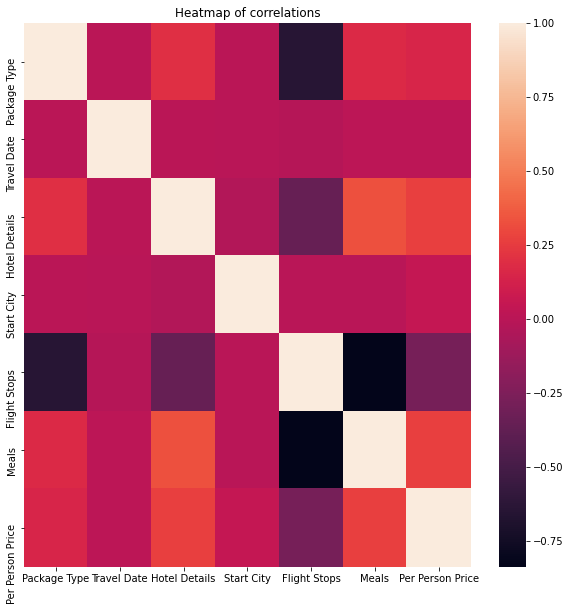

In [77]:
c = train[train.columns[:7]].corr()
plt.figure(figsize=(10,10))
sns.heatmap(c)
plt.title('Heatmap of correlations')
plt.show()

In [78]:
train.drop(['Start City'], axis=1, inplace=True)
train

,Package Type,Travel Date,Hotel Details,Flight Stops,Meals,Per Person Price,Nights in Tiruchirapally,Nights in Lucknow,Nights in Srinagar,Nights in Sigiriya,Nights in Rotorua,Nights in Shirdi,Nights in Shillong,Nights in Kanyakumari,Nights in Praslin Island,Nights in Singapore,Nights in Ganpatipule,Nights in Thekkady,Nights in Penang,Nights in Thimpu,Nights in Nameri,Nights in Nanded,Nights in Varkala,Nights in Phuentsholing,Nights in Daman,Nights in Mumbai,Nights in Johor Bahru,Nights in Kumarakom,Nights in Kovalam,Nights in Cochin,Nights in Orchha,Nights in Dubai,Nights in Amritsar,Nights in Batam,Nights in Goa,Nights in Kalimpong,Nights in Pattaya,Nights in Patnitop,Nights in Copenhagen,Nights in Ahmednagar,...,Nights in Agra,Nights in Pahalgam,Nights in Rameshwaram,Nights in Moscow,Nights in Gwalior,Nights in Bundi,Nights in Langkawi,Nights in Tirupati,Nights in Kuta,Nights in Kumbalgarh,Nights in Kovalam and Poovar,Nights in Lachung,Nights in Kuala Lumpur,Nights in Ranikhet,Nights in Sonmarg,Nights in Hampi,Nights in Seminyak,Nights in Nubra Valley,Nights in Corbett,Nights in Kasol,Nights in Jaisalmer,Nights in Hassan,Nights in Madurai,Nights in Tanjore,Nights in Somnath,Nights in Vadodara,Nights in Cherrapunjee,Nights in Khajuraho,Nights in Phuket,Nights in Kausani,Nights in Punakha,Nights in Queenstown,Nights in Udaipur,Nights in Chittorgarh,Nights in Jamnagar,Nights in Pali,Nights in Guwahati,Nights in Trivandrum,Nights in Cairns,Nights in Kanchipuram
0,1,7,3.000000,2,3,11509.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,8,4.433333,0,5,22485.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,4,4.200000,0,4,12421.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,8,4.125000,0,5,35967.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,12,4.350000,0,5,25584.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,3,4,4.000000,1,3,16168.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20996,4,8,4.300000,0,4,33770.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [79]:
 test= process_test_data(test)
 test

['Month #1', 'Month #2', 'Month #3', 'Month #4', 'Month #5', 'Month #6', 'Month #7', 'Month #8', 'Month #9', 'Month #10', 'Month #11', 'Month #12']
      Month #1  Month #2  Month #3  ...  Month #10  Month #11  Month #12
0          0.0       0.0       0.0  ...        0.0        0.0        0.0
1          0.0       0.0       1.0  ...        0.0        0.0        0.0
2          0.0       0.0       0.0  ...        0.0        0.0        0.0
3          0.0       0.0       0.0  ...        0.0        0.0        0.0
4          0.0       0.0       0.0  ...        1.0        0.0        0.0
...        ...       ...       ...  ...        ...        ...        ...
8995       0.0       0.0       0.0  ...        0.0        0.0        0.0
8996       0.0       0.0       0.0  ...        0.0        0.0        0.0
8997       0.0       0.0       0.0  ...        0.0        0.0        0.0
8998       0.0       0.0       1.0  ...        0.0        0.0        0.0
8999       0.0       1.0       0.0  ...        0.

,National Trip,Package Type,Hotel Details,Flight Stops,Meals,Nights in Tiruchirapally,Nights in Lucknow,Nights in Srinagar,Nights in Sigiriya,Nights in Rotorua,Nights in Shirdi,Nights in Shillong,Nights in Kanyakumari,Nights in Praslin Island,Nights in Singapore,Nights in Ganpatipule,Nights in Thekkady,Nights in Penang,Nights in Thimpu,Nights in Nameri,Nights in Nanded,Nights in Varkala,Nights in Phuentsholing,Nights in Daman,Nights in Mumbai,Nights in Johor Bahru,Nights in Kumarakom,Nights in Kovalam,Nights in Cochin,Nights in Orchha,Nights in Dubai,Nights in Amritsar,Nights in Batam,Nights in Goa,Nights in Kalimpong,Nights in Pattaya,Nights in Patnitop,Nights in Copenhagen,Nights in Ahmednagar,Nights in Ajmer,...,Nights in Kuala Lumpur,Nights in Ranikhet,Nights in Sonmarg,Nights in Hampi,Nights in Seminyak,Nights in Nubra Valley,Nights in Corbett,Nights in Kasol,Nights in Jaisalmer,Nights in Hassan,Nights in Madurai,Nights in Tanjore,Nights in Somnath,Nights in Vadodara,Nights in Cherrapunjee,Nights in Khajuraho,Nights in Phuket,Nights in Kausani,Nights in Punakha,Nights in Queenstown,Nights in Udaipur,Nights in Chittorgarh,Nights in Jamnagar,Nights in Pali,Nights in Guwahati,Nights in Trivandrum,Nights in Cairns,Nights in Kanchipuram,Month #1,Month #2,Month #3,Month #4,Month #5,Month #6,Month #7,Month #8,Month #9,Month #10,Month #11,Month #12
0,0.0,4,4.100000,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4,4.400000,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1,3.000000,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,3,3.000000,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4,3.775000,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1.0,1,3.333333,2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8996,1.0,3,3.000000,1,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8997,0.0,4,4.250000,0,4

In [80]:
#dont run
c = [i for i in range(13)]
c.remove(0)
colname = ['Month #' + str(i) for i in c]
colname
A = pd.DataFrame(np.zeros((train.shape[0],len(colname))))
A.columns = colname
for i in range(train.shape[0]):
  d = int(train.iloc[i]['Travel Date'])
  g = colname[d-1]
  A.iloc[i][g] = 1
train = pd.concat([train,A],axis=1)
train.drop('Travel Date',axis=1,inplace=True)

In [81]:
data = np.asarray(train['Per Person Price'])
scaled = scaler.fit_transform(data.reshape(-1, 1))
train['Per Person Price'] = scaled
train

,Package Type,Hotel Details,Flight Stops,Meals,Per Person Price,Nights in Tiruchirapally,Nights in Lucknow,Nights in Srinagar,Nights in Sigiriya,Nights in Rotorua,Nights in Shirdi,Nights in Shillong,Nights in Kanyakumari,Nights in Praslin Island,Nights in Singapore,Nights in Ganpatipule,Nights in Thekkady,Nights in Penang,Nights in Thimpu,Nights in Nameri,Nights in Nanded,Nights in Varkala,Nights in Phuentsholing,Nights in Daman,Nights in Mumbai,Nights in Johor Bahru,Nights in Kumarakom,Nights in Kovalam,Nights in Cochin,Nights in Orchha,Nights in Dubai,Nights in Amritsar,Nights in Batam,Nights in Goa,Nights in Kalimpong,Nights in Pattaya,Nights in Patnitop,Nights in Copenhagen,Nights in Ahmednagar,Nights in Ajmer,...,Nights in Kuala Lumpur,Nights in Ranikhet,Nights in Sonmarg,Nights in Hampi,Nights in Seminyak,Nights in Nubra Valley,Nights in Corbett,Nights in Kasol,Nights in Jaisalmer,Nights in Hassan,Nights in Madurai,Nights in Tanjore,Nights in Somnath,Nights in Vadodara,Nights in Cherrapunjee,Nights in Khajuraho,Nights in Phuket,Nights in Kausani,Nights in Punakha,Nights in Queenstown,Nights in Udaipur,Nights in Chittorgarh,Nights in Jamnagar,Nights in Pali,Nights in Guwahati,Nights in Trivandrum,Nights in Cairns,Nights in Kanchipuram,Month #1,Month #2,Month #3,Month #4,Month #5,Month #6,Month #7,Month #8,Month #9,Month #10,Month #11,Month #12
0,1,3.000000,2,3,-0.734352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,4.433333,0,5,0.208374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,4.200000,0,4,-0.655981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,4.125000,0,5,1.366243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2,4.350000,0,5,0.474491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,3,4.000000,1,3,-0.334167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20996,4,4.300000,0,4,1.177595,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [82]:
train.describe()

,Package Type,Hotel Details,Flight Stops,Meals,Per Person Price,Nights in Tiruchirapally,Nights in Lucknow,Nights in Srinagar,Nights in Sigiriya,Nights in Rotorua,Nights in Shirdi,Nights in Shillong,Nights in Kanyakumari,Nights in Praslin Island,Nights in Singapore,Nights in Ganpatipule,Nights in Thekkady,Nights in Penang,Nights in Thimpu,Nights in Nameri,Nights in Nanded,Nights in Varkala,Nights in Phuentsholing,Nights in Daman,Nights in Mumbai,Nights in Johor Bahru,Nights in Kumarakom,Nights in Kovalam,Nights in Cochin,Nights in Orchha,Nights in Dubai,Nights in Amritsar,Nights in Batam,Nights in Goa,Nights in Kalimpong,Nights in Pattaya,Nights in Patnitop,Nights in Copenhagen,Nights in Ahmednagar,Nights in Ajmer,...,Nights in Kuala Lumpur,Nights in Ranikhet,Nights in Sonmarg,Nights in Hampi,Nights in Seminyak,Nights in Nubra Valley,Nights in Corbett,Nights in Kasol,Nights in Jaisalmer,Nights in Hassan,Nights in Madurai,Nights in Tanjore,Nights in Somnath,Nights in Vadodara,Nights in Cherrapunjee,Nights in Khajuraho,Nights in Phuket,Nights in Kausani,Nights in Punakha,Nights in Queenstown,Nights in Udaipur,Nights in Chittorgarh,Nights in Jamnagar,Nights in Pali,Nights in Guwahati,Nights in Trivandrum,Nights in Cairns,Nights in Kanchipuram,Month #1,Month #2,Month #3,Month #4,Month #5,Month #6,Month #7,Month #8,Month #9,Month #10,Month #11,Month #12
count,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000
mean,2.283857,3.801991,0.870286,3.665429,-1.072052e-16,0.003714,0.000905,0.109286,0.003381,0.001143,0.008952,0.046619,0.016190,0.000571,0.052667,0.001095,0.093381,0.001381,0.010524,0.002286,0.00019,0.002571,0.000714,0.000095,0.001619,0.001048,0.032429,0.026905,0.050143,0.000143,0.058762,0.041952,0.002429,0.165286,0.022905,0.025619,0.002333,0.001429,0.000286,0.003143,...,0.047429,0.010190,0.000333,0.001238,0.001238,0.001190,0.039667,0.006857,0.051619,0.001238,0.019476,0.004048,0.001095,0.001238,0.004905,0.000286,0.019000,0.00600,0.003000,0.005238,0.120000,0.003619,0.000476,0.001000,0.02781,0.001429,0.000571,0.000571,0.055667,0.079667,0.087857,0.092429,0.095667,0.092095,0.092905,0.092381,0.085714,0.086476,0.07719,0.061952
std,1.090219,0.556569,0.834989,0.893631,1.000024e+00,0.060833,0.030066,0.488848,0.058049,0.047797,0.121955,0.338588,0.131024,0.033802,0.433476,0.044173,0.341565,0.061320,0.158670,0.067575,0.01380,0.050645,0.026717,0.009759,0.048769,0.037783,0.226460,0.225921,0.237272,0.011952,0.497218,0.270459,0.066505,0.798151,0.173482,0.287046,0.048249,0.065451,0.016901,0.055974,...,0.387723,0.125325,0.018255,0.049747,0.049747,0.043079,0.278605,0.116910,0.323091,0.049747,0.158424,0.063494,0.033077,0.049747,0.092711,0.023903,0.237995,0.10218,0.069971,0.144987,0.498753,0.060051,0.021817,0.035844,0.21512,0.037770,0.033802,0.023898,0.229282,0.270783,0.283094,0.289637,0.294141,0.289167,0.290306,0.289570,0.279948,0.281073,0.26690,0.241075
min,0.000000,1.900000,0.000000,2.000000,-1.654877e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [83]:
train.iloc[20997]

Package Type        3.000000
Hotel Details       4.000000
Flight Stops        1.000000
Meals               3.000000
Per Person Price    0.850671
                      ...   
Month #8            0.000000
Month #9            0.000000
Month #10           0.000000
Month #11           0.000000
Month #12           0.000000
Name: 20997, Length: 196, dtype: float64

In [84]:
A = create_nation_column(train)
train = pd.concat([A,train],axis = 1)
train.rename(columns = {0: 'National Trip'}, inplace = True) 
train

Lucknow
Srinagar
Shirdi
Shillong
Kanyakumari
Ganpatipule
Thekkady
Nanded
Varkala
Daman
Mumbai
Kumarakom
Kovalam
Cochin
Orchha
Amritsar
Goa
Kalimpong
Patnitop
Ahmednagar
Ajmer
New Delhi
Ooty
Chennai
Haridwar
Joshimath
Chintpurni
Wayanad
Dwarka
Chandigarh
Alwar
Ranthambhore
Katra
Dharamshala
Gulmarg
Coorg
Kabini
Kodaikanal
Ranakpur
Nawalgarh
Darjeeling
Namchi
Bikaner
Dalhousie
Allepey
Shimla
Lonavala And Khandala
Gokarna
Munnar
Parwanoo
Jammu
Bangalore
Mysore
Palampur
Mount Abu
Leh
Pushkar
Mandawa
Poovar
Ahmedabad
Varanasi
Kasauli
Jodhpur
Kaziranga
Bharatpur
Mathura
Almora
Saputara
Port Blair
Gangtok
Siliguri
Mussoorie
Jaipur
Kishangarh
Manali
Nainital
Pelling
Pondicherry
Kullu
Rishikesh
Kumbakonam
Mahabalipuram
Nasik
Kangra
Aurangabad
Agra
Pahalgam
Rameshwaram
Gwalior
Bundi
Tirupati
Kumbalgarh
Kovalam and Poovar
Lachung
Ranikhet
Sonmarg
Hampi
Nubra Valley
Kasol
Jaisalmer
Hassan
Madurai
Tanjore
Somnath
Vadodara
Cherrapunjee
Khajuraho
Kausani
Udaipur
Chittorgarh
Jamnagar
Pali
Guwahati
Tri

,National Trip,Package Type,Hotel Details,Flight Stops,Meals,Per Person Price,Nights in Tiruchirapally,Nights in Lucknow,Nights in Srinagar,Nights in Sigiriya,Nights in Rotorua,Nights in Shirdi,Nights in Shillong,Nights in Kanyakumari,Nights in Praslin Island,Nights in Singapore,Nights in Ganpatipule,Nights in Thekkady,Nights in Penang,Nights in Thimpu,Nights in Nameri,Nights in Nanded,Nights in Varkala,Nights in Phuentsholing,Nights in Daman,Nights in Mumbai,Nights in Johor Bahru,Nights in Kumarakom,Nights in Kovalam,Nights in Cochin,Nights in Orchha,Nights in Dubai,Nights in Amritsar,Nights in Batam,Nights in Goa,Nights in Kalimpong,Nights in Pattaya,Nights in Patnitop,Nights in Copenhagen,Nights in Ahmednagar,...,Nights in Kuala Lumpur,Nights in Ranikhet,Nights in Sonmarg,Nights in Hampi,Nights in Seminyak,Nights in Nubra Valley,Nights in Corbett,Nights in Kasol,Nights in Jaisalmer,Nights in Hassan,Nights in Madurai,Nights in Tanjore,Nights in Somnath,Nights in Vadodara,Nights in Cherrapunjee,Nights in Khajuraho,Nights in Phuket,Nights in Kausani,Nights in Punakha,Nights in Queenstown,Nights in Udaipur,Nights in Chittorgarh,Nights in Jamnagar,Nights in Pali,Nights in Guwahati,Nights in Trivandrum,Nights in Cairns,Nights in Kanchipuram,Month #1,Month #2,Month #3,Month #4,Month #5,Month #6,Month #7,Month #8,Month #9,Month #10,Month #11,Month #12
0,1.0,1,3.000000,2,3,-0.734352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,4.433333,0,5,0.208374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,4,4.200000,0,4,-0.655981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2,4.125000,0,5,1.366243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,2,4.350000,0,5,0.474491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1.0,3,4.000000,1,3,-0.334167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20996,1.0,4,4.300000,0,4,1.177595,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41002dff10>,
      dtype=object)

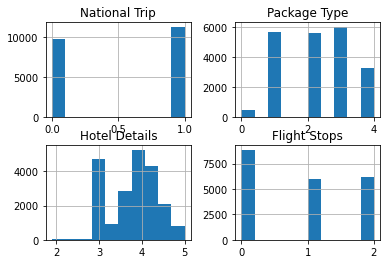

In [85]:
train[train.columns[:4]].hist()

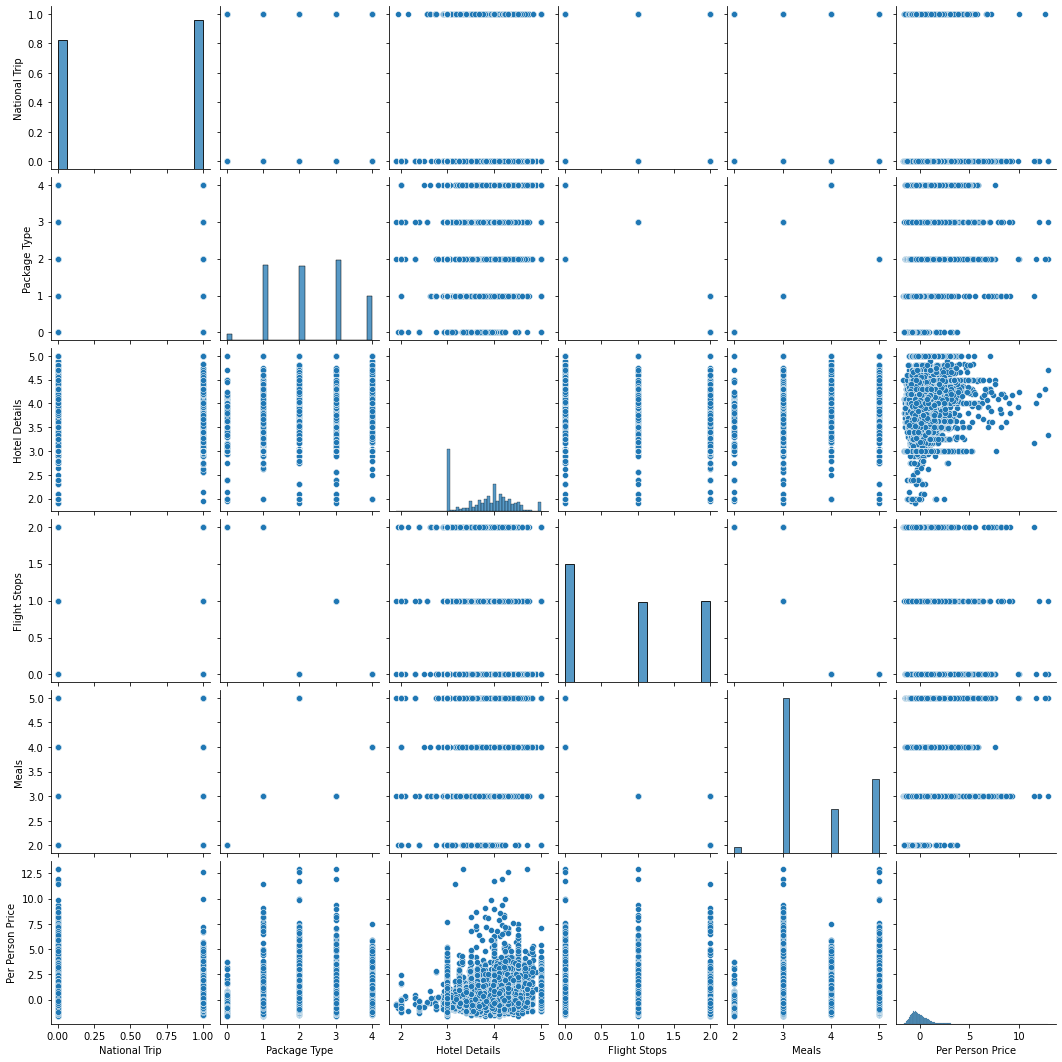

In [92]:
sns.pairplot(train[train.columns[:6]])

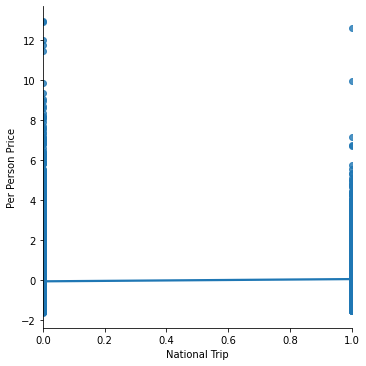

In [87]:
sns.lmplot(x=train.columns[0], y = 'Per Person Price', data=train)

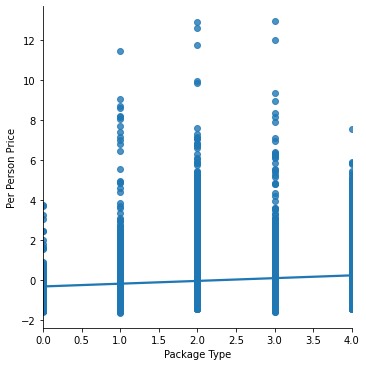

In [88]:
sns.lmplot(x=train.columns[1], y = 'Per Person Price', data=train)

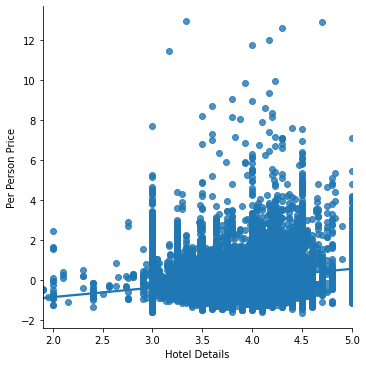

In [89]:
sns.lmplot(x=train.columns[2], y = 'Per Person Price', data=train)

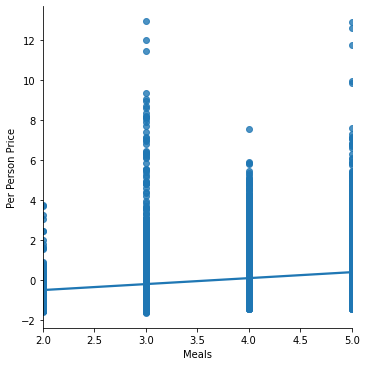

In [ ]:
sns.lmplot(x=train.columns[3], y = 'Per Person Price', data=train)

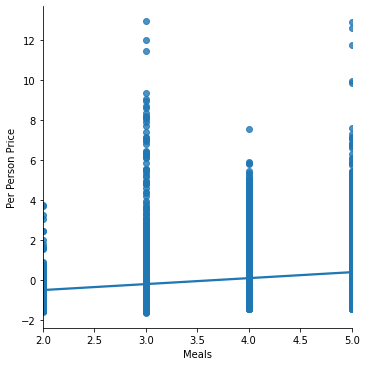

In [91]:
sns.lmplot(x=train.columns[4], y = 'Per Person Price', data=train)

Train Test Split

In [94]:
feature_cols = set(train.columns) - set('Per Person Price')
X = train.drop('Per Person Price', axis = 1)
Y = train['Per Person Price']
X_train, X_CV, Y_train, Y_CV = train_test_split(X,Y)
Y_CV = scaler.inverse_transform(np.asarray(Y_CV).reshape(-1,1))

In [95]:
regressor = SVR(kernel = 'rbf', C =3 , epsilon = 0.1) #C = 0.1

In [96]:
regressor.fit(X_train, Y_train)

SVR(C=3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [97]:
Y_p = regressor.predict(X_CV)
Y_p = scaler.inverse_transform(np.asarray(Y_p).reshape(-1,1))

In [ ]:
Y_p[Y_p<0] = Y_p[Y_p<0] * -1

In [98]:
s = get_log_error(Y_CV, Y_p)
s = str(s)[:6]
print(s)

0.2636


In [99]:
Y_CV

array([[15538.5],
       [29382.5],
       [37909.5],
       ...,
       [13581.5],
       [ 9600.5],
       [20635. ]])

In [100]:
Y_p

array([[13533.91095313],
       [29987.81263267],
       [34936.65371212],
       ...,
       [14800.08535151],
       [10760.66207309],
       [22074.22143267]])

In [ ]:
s = get_log_error(Y_CV, Y_p)
s = str(s)[:6]
print(s)
create_submission(test, regressor, s)

0.3255
--Ready--


In [ ]:
C = [3,5,10,12]
epsilon = [i for i in np.arange(0.01,1,0.03)]
gamma = [1,0.1,0.01,0.001,0.0001]
param_grid = {'C':C,
              'epsilon': [0.1],
              'gamma':gamma
              }

In [ ]:
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose= 10, n_jobs= 5)
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 21.0min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 38.3min
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed: 44.4min
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  25 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  29 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed: 52.5min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 52.5min


KeyboardInterrupt: ignored

In [ ]:
print(grid.best_params_)

In [ ]:
XGBModel = XGBRegressor()

In [ ]:
XGBModel.fit(X_train, Y_train , verbose=False)
# Get the mean absolute error on the validation data :
Y_p  = XGBModel.predict(X_CV)
Y_p = scaler.inverse_transform(np.asarray(Y_p).reshape(-1,1))

[10:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
grid1 =  = GridSearchCV(XGBRegressor(), param_grid, refit = True, verbose= 10, n_jobs= 5)
grid.fit(X, Y)

print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
s = get_log_error(Y_CV, Y_p)
s = str(s)[:6]
print(s)
#create_submission(test, regressor, s)

0.4141


In [ ]:
filtered_ =[]
places =[i for i in train.columns if 'Nights in' in i]
if 
for i in places:
  if nation(i.split('Nights in ')[1] ).strip() is not 'India':
   
  filtered_.append(i.split('Nights in ')[1])
filtered_



India
1
India
1
